In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
from datetime import timedelta

file_path="./files/mimiciii/1.4/"

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 300)

In [3]:
adm=pd.read_csv(file_path+"Admissions_processed.csv")

In [4]:
adm.head()

,Unnamed: 0,SUBJECT_ID,DOBTIME,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ELAPSED_TIME,ELAPSED_DAYS,DEATHTAG
0,3,250,2164-12-27 00:00:00,324,124271,2188-11-12 09:22:00,2188-11-22 12:00:00,2188-11-22 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Self Pay,HAIT,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,2188-11-12 06:56:00,2188-11-12 10:10:00,PNEUMONIA;R/O TB,1,1,10 days 02:38:00,10,1
1,7,253,2089-11-26 00:00:00,328,176189,2174-01-21 20:58:00,2174-01-26 16:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,SNF,Medicare,NaN,CATHOLIC,WIDOWED,WHITE,NaN,NaN,COMPLETE HEART BLOCK\PACEMAKER IMPLANT,0,1,4 days 19:17:00,4,0
2,8,255,2109-08-05 00:00:00,329,112013,2187-02-12 10:30:00,2187-02-15 10:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,BENIGN PROSTATIC HYPERTROPHY/SDA,0,1,3 days 00:00:00,3,0
3,16,261,2025-08-04 00:00:00,337,118523,2101-12-27 01:50:00,2102-01-12 13:39:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Medicare,NaN,OTHER,MARRIED,WHITE,2101-12-26 20:11:00,2101-12-27 01:50:00,HYPOXIA,0,1,16 days 11:49:00,16,0
4,17,262,2090-01-05 00:00:00,338,106019,2153-09-25 18:01:00,2153-09-28 18:48:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HYPERTROPHIC CARDIOMYOPATHY\ETHANOL SEPTAL ABL...,0,1,3 days 00:47:00,3,0


We now consider the labevents dataset. We select only the patients with the same criteria as above.

In [5]:
lab=pd.read_csv(file_path+"LABEVENTS.csv")

#Restrict the dataset to the previously selected admission ids only.
adm_ids=list(adm["HADM_ID"])
lab=lab.loc[lab["HADM_ID"].isin(adm_ids)]

print("Number of patients remaining in the database: ")
print(lab["SUBJECT_ID"].nunique())

Number of patients remaining in the database: 
24642


We load the D_ITEMS dataframe which contains the name of the ITEMID. And we merge both tables together.

In [7]:
#item_id
item_id=pd.read_csv(file_path+"D_LABITEMS.csv")
item_id_1=item_id[["ITEMID","LABEL"]]
item_id_1.head()

#We merge the name of the item administrated.
lab2=pd.merge(lab,item_id_1,on="ITEMID")
lab2.head()
print("Number of patients remaining in the database: ")
print(lab2["SUBJECT_ID"].nunique())

Number of patients remaining in the database: 
24642


In [8]:
n_best=150
#For each item, evaluate the number of patients who have been given this item.
pat_for_item=lab2.groupby("LABEL")["SUBJECT_ID"].nunique()
#Order by occurence and take the 20 best (the ones with the most patients)
frequent_labels=pat_for_item.sort_values(ascending=False)[:n_best]

#Select only the time series with high occurence.
lab3=lab2.loc[lab2["LABEL"].isin(list(frequent_labels.index))].copy()

print("Number of patients remaining in the database: ")
print(lab3["SUBJECT_ID"].nunique())

Number of patients remaining in the database: 
24642


### Units Cleaning

#### 1) In amounts

In [9]:
#Verification that all input labels have the same amounts units.
print(lab3.groupby("LABEL")["VALUEUOM"].value_counts())

#Correct the units
lab3.loc[lab3["LABEL"]=="Calculated Total CO2","VALUEUOM"]="mEq/L"
lab3.loc[lab3["LABEL"]=="PT","VALUEUOM"]="sec"
lab3.loc[lab3["LABEL"]=="pCO2","VALUEUOM"]="mm Hg"
lab3.loc[lab3["LABEL"]=="pH","VALUEUOM"]="units"
lab3.loc[lab3["LABEL"]=="pO2","VALUEUOM"]="mm Hg"

LABEL                                VALUEUOM
% Hemoglobin A1c                     %             4635
Acetaminophen                        ug/mL         3610
Alanine Aminotransferase (ALT)       IU/L         58702
Albumin                              g/dL         38849
Alkaline Phosphatase                 IU/L         56854
Alveolar-arterial Gradient           mm Hg         7675
Amylase                              IU/L         21678
Anion Gap                            mEq/L       262969
Asparate Aminotransferase (AST)      IU/L         58640
Atypical Lymphocytes                 %            12879
Bands                                %            17687
Base Excess                          mEq/L       229451
Basophils                            %            40307
Bicarbonate                          mEq/L       269058
Bilirubin                            EU/dL        18614
                                     mg/dL        12557
Bilirubin, Direct                    mg/dL         4710
Bi

In [10]:
#Only select the subset that was used in the paper (only missing is INR(PT))
subset=["Albumin","Alanine Aminotransferase (ALT)","Alkaline Phosphatase","Anion Gap","Asparate Aminotransferase (AST)","Base Excess","Basophils","Bicarbonate","Bilirubin, Total","Calcium, Total","Calculated Total CO2","Chloride","Creatinine","Eosinophils","Glucose","Hematocrit","Hemoglobin",
"Lactate","Lymphocytes","MCH","MCHC","MCV","Magnesium","Monocytes","Neutrophils","PT","PTT","Phosphate","Platelet Count","Potassium","RDW","Red Blood Cells","Sodium","Specific Gravity","Urea Nitrogen","White Blood Cells","pCO2","pH","pO2"]

lab3=lab3.loc[lab3["LABEL"].isin(subset)].copy()


### Check for outliers

#### 1) In amounts

In [11]:
lab3.groupby("LABEL")["VALUENUM"].describe()

,count,mean,std,min,25%,50%,75%,max
LABEL,,,,,,,,
Alanine Aminotransferase (ALT),58697.0,215.854904,806.312662,0.000,21.00,40.000,96.00,25460.00
Albumin,38841.0,3.032422,0.692599,1.000,2.50,3.000,3.50,6.40
Alkaline Phosphatase,56854.0,140.733299,166.023159,0.000,66.00,94.000,151.00,4695.00
Anion Gap,262985.0,13.510965,3.626430,-6.000,11.00,13.000,15.00,67.00
Asparate Aminotransferase (AST),58640.0,238.205832,1034.628934,0.000,26.00,47.000,105.00,36400.00
Base Excess,229420.0,-0.036823,4.952865,-414.000,-2.00,0.000,2.00,162.00
Basophils,40307.0,0.294470,0.479617,0.000,0.00,0.200,0.40,40.00
Bicarbonate,269032.0,25.331971,4.684684,2.000,23.00,25.000,28.00,53.00
"Bilirubin, Total",58902.0,3.266241,6.579278,0.000,0.50,0.900,2.50,82.80


In [12]:
#Glucose : mettre -1 aux résultats négatifs et supprimer les autres entrées dont la valeur numérique est NaN.
lab3.loc[(lab3["LABEL"]=="Glucose")&(lab3["VALUENUM"].isnull())&(lab3["VALUE"]=="NEG"),"VALUENUM"]=-1
lab3=lab3.drop(lab3.loc[(lab3["LABEL"]=="Glucose")&(lab3["VALUENUM"].isnull())].index).copy()

#Retirer les entrées avec NaN aux values et valuenum
lab3=lab3.drop(lab3.loc[(lab3["VALUENUM"].isnull())&(lab3["VALUE"].isnull())].index).copy()

#Remove the remaining NAN Values
lab3=lab3.drop(lab3.loc[(lab3["VALUENUM"].isnull())].index).copy()

#Remove anion gaps lower than 0
lab3=lab3.drop(lab3.loc[(lab3["VALUENUM"]<0)&(lab3["LABEL"]=="Anion Gap")].index).copy()

#Remove BE <-50
lab3=lab3.drop(lab3.loc[(lab3["LABEL"]=="Base Excess")&(lab3["VALUENUM"]<-50)].index).copy()
#Remove BE >50
lab3=lab3.drop(lab3.loc[(lab3["LABEL"]=="Base Excess")&(lab3["VALUENUM"]>50)].index).copy()

#Remove high Hemoglobins
lab3=lab3.drop(lab3.loc[(lab3["LABEL"]=="Hemoglobin")&(lab3["VALUENUM"]>25)].index).copy()

#Clean some glucose entries
lab3=lab3.drop(lab3.loc[(lab3["LABEL"]=="Glucose")&(lab3["VALUENUM"]>2000)&(lab3["HADM_ID"]==103500.0)].index).copy()
lab3=lab3.drop(lab3.loc[(lab3["LABEL"]=="Glucose")&(lab3["VALUENUM"]>2000)&(lab3["HADM_ID"]==117066.0)].index).copy()

#Clean toO high levels of Potassium
lab3=lab3.drop(lab3.loc[(lab3["LABEL"]=="Potassium")&(lab3["VALUENUM"]>30)].index).copy()


In [13]:
lab3.to_csv(file_path+"LAB_processed.csv")

In [14]:
#Merge the admission time.
adm_short=adm[["HADM_ID","ADMITTIME","ELAPSED_TIME","DEATHTAG"]]
lab4=pd.merge(lab3,adm_short,on="HADM_ID")
lab4['CHARTTIME']=pd.to_datetime(lab4["CHARTTIME"], format='%Y-%m-%d %H:%M:%S')
#lab4['ADMITTIME']=pd.to_datetime(lab4["ADMITTIME"], format='%Y-%m-%d %H:%M:%S')

In [15]:
#Set the reference time as the admission time for each admission.
ref_time=lab4.groupby("HADM_ID")["CHARTTIME"].min()
#ref_time=lab4.groupby("HADM_ID")["ADMITTIME"].min()
lab5=pd.merge(ref_time.to_frame(name="REF_TIME"),lab4,left_index=True,right_on="HADM_ID")
lab5["TIME_STAMP"]=lab5["CHARTTIME"]-lab5["REF_TIME"]
assert(len(lab5.loc[lab5["TIME_STAMP"]<timedelta(hours=0)].index)==0)

In [16]:
#Create a label code (int) for the labels.
label_dict=dict(zip(list(lab5["LABEL"].unique()),range(len(list(lab5["LABEL"].unique())))))
lab5["LABEL_CODE"]=lab5["LABEL"].map(label_dict)
lab_short=lab5[["SUBJECT_ID","HADM_ID","VALUENUM","TIME_STAMP","LABEL_CODE","DEATHTAG"]]


#### Time binning of the data
First we select the data up to a certain time limit (48 hours)

In [17]:
#Now only select values within 48 hours.
lab_short=lab_short.loc[(lab_short["TIME_STAMP"]<timedelta(hours=48))]
print("Number of patients considered :"+str(lab_short["SUBJECT_ID"].nunique()))

Number of patients considered :24642


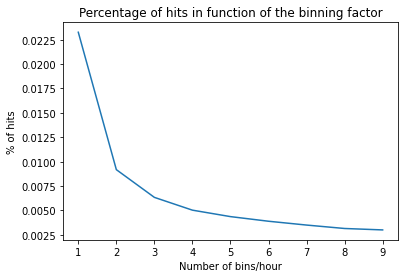

In [18]:
#Plot the number of "hits" based on the binning. That is, the number of measurements falling into the same bin in function of the number of bins
bins_num=range(1,10)
lab_short_binned=lab_short.copy()
hits_vec=[]
for bin_k in bins_num:
    time_stamp_str="TIME_STAMP_Bin_"+str(bin_k)
    lab_short_binned[time_stamp_str]=round(lab_short_binned["TIME_STAMP"].dt.total_seconds()*bin_k/(100*36)).astype(int)
    hits_prop=lab_short_binned.duplicated(subset=["HADM_ID","LABEL_CODE",time_stamp_str]).sum()/len(lab_short_binned.index)
    hits_vec+=[hits_prop]
plt.plot(bins_num,hits_vec)
plt.title("Percentage of hits in function of the binning factor")
plt.xlabel("Number of bins/hour")
plt.ylabel("% of hits")
plt.show()

In [19]:
#We then choose a binning factor of 2. 
#Set the time as an integer. We take 2 bins per hour
lab_short["TIME_STAMP"]=round(lab_short["TIME_STAMP"].dt.total_seconds()*2/(100*36)).astype(int)
#Then sort the dataframe with order : Admission ID, Label Code and time stamps
lab_short=lab_short.sort_values(by=["HADM_ID","LABEL_CODE","TIME_STAMP"],ascending=[1,1,1])

In [20]:
lab_short.duplicated(subset=["HADM_ID","LABEL_CODE","TIME_STAMP"]).value_counts()

False    2716876
True       25179
dtype: int64

In [21]:
#Then save locally
lab_short.to_csv(file_path+"lab_events_short.csv")

In [22]:
len(lab_short.index)/(22000*39*100)

0.031958682983682984

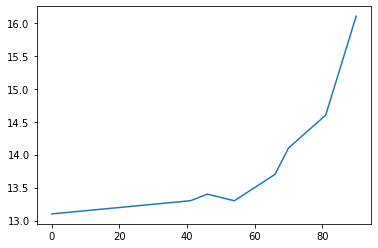

In [23]:
#Example of time series for an ICU stay.
plt.plot(lab_short.loc[(lab_short["HADM_ID"]==130421)&(lab_short["LABEL_CODE"]==25),"TIME_STAMP"],lab_short.loc[(lab_short["HADM_ID"]==130421)&(lab_short["LABEL_CODE"]==25),"VALUENUM"])
plt.show()

In [24]:
#Create an extra dataset with the deathtags of each hadm_id.
death_tags_s=lab_short.groupby("HADM_ID")["DEATHTAG"].unique().astype(int)
death_tags_df=pd.DataFrame({"HADM_ID":death_tags_s.index,"DEATHTAG":death_tags_s.values})
death_tags_df.to_csv(file_path+"death_tags.csv")

### Dataset creation for LSTM operation (One sample = one patient history)

In [25]:
#Transform the dataframe as one row per patient/feature (for LSTM operation)
import numpy as np
results=[]
unique_hadms=lab_short["HADM_ID"].unique()
for lab_code in range(30):
    lab_short=lab_short.drop_duplicates(["LABEL_CODE","TIME_STAMP","HADM_ID"])
    lab_code_view=lab_short.loc[lab_short["LABEL_CODE"]==lab_code]
    pivoted=lab_code_view.pivot(index="HADM_ID",columns="TIME_STAMP",values="VALUENUM").reset_index()
    pivoted["LABEL_CODE"]=lab_code
    
    non_code=lab_short.loc[lab_short["LABEL_CODE"]==lab_code,"HADM_ID"].unique()
    missing_hadms=np.setdiff1d(unique_hadms,non_code)
    
    df_missing_hadms=pd.DataFrame(data=np.vstack((missing_hadms,lab_code*np.ones(missing_hadms.shape))).T,columns=["HADM_ID","LABEL_CODE"])
    pivoted_full=pd.concat([pivoted,df_missing_hadms])
    
    results.append(pd.merge(pivoted_full,death_tags_df,on="HADM_ID"))
df_pre_proc=pd.concat(results)

#We create a new HADM_ID which goes from 0 to nunique()
d=dict(zip(df_pre_proc["HADM_ID"].unique(),range(df_pre_proc["HADM_ID"].nunique())))
df_pre_proc["UNIQUE_ID"]=df_pre_proc["HADM_ID"].map(d)

df_pre_proc.to_csv(file_path+"lab_short_pre_proc.csv")

In [26]:
#Divide the LSTM dataset in train/val/test sets and save them locally.
val_num=int(0.2*df_pre_proc["UNIQUE_ID"].nunique())
test_num=int(0.1*df_pre_proc["UNIQUE_ID"].nunique())

patients_list=df_pre_proc["UNIQUE_ID"].unique()
validation_choice=np.random.choice(patients_list,size=val_num,replace=False)
patients_list=np.setdiff1d(patients_list,validation_choice)
test_choice=np.random.choice(patients_list,size=test_num,replace=False)
patients_list=np.setdiff1d(patients_list,test_choice)

df_val=df_pre_proc.loc[df_pre_proc["UNIQUE_ID"].isin(validation_choice)]
d=dict(zip(df_val["UNIQUE_ID"].unique(),range(df_val["UNIQUE_ID"].nunique())))
df_val["UNIQUE_ID"].replace(d,inplace=True)

df_test=df_pre_proc.loc[df_pre_proc["UNIQUE_ID"].isin(test_choice)]
d=dict(zip(df_test["UNIQUE_ID"].unique(),range(df_test["UNIQUE_ID"].nunique())))
df_test["UNIQUE_ID"].replace(d,inplace=True)

df_train=df_pre_proc.loc[df_pre_proc["UNIQUE_ID"].isin(patients_list)]
d=dict(zip(df_train["UNIQUE_ID"].unique(),range(df_train["UNIQUE_ID"].nunique())))
df_train["UNIQUE_ID"].replace(d,inplace=True)

assert((len(df_val.index)+len(df_test.index)+len(df_train.index))==len(df_pre_proc.index))

df_val.to_csv(file_path+"lab_short_pre_proc_val.csv")
df_test.to_csv(file_path+"lab_short_pre_proc_test.csv")
df_train.to_csv(file_path+"lab_short_pre_proc_train.csv")

/data/hzy/anaconda3/envs/mimic_prepare/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


### Dataframe creation for Tensor Factorization

In [27]:
#We copy the lab_short with the required columns
lab_short_tensor=lab_short[["HADM_ID","VALUENUM","TIME_STAMP","LABEL_CODE","DEATHTAG"]].copy()
#Creation of a unique index
d=dict(zip(lab_short_tensor["HADM_ID"].unique(),range(lab_short_tensor["HADM_ID"].nunique())))
lab_short_tensor["UNIQUE_ID"]=lab_short_tensor["HADM_ID"].map(d)
#Apply the same unique index for the death tags.
death_tags_df["UNIQUE_ID"]=death_tags_df["HADM_ID"].map(d)
death_tags_df.to_csv(file_path+"death_tag_tensor.csv")

In [29]:
ICD_diag=pd.read_csv(file_path+"DIAGNOSES_ICD.csv")
ICD_diag

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


In [30]:
main_diag=ICD_diag.loc[(ICD_diag["SEQ_NUM"]==1)]
lab_short_tensor_m=pd.merge(lab_short_tensor,main_diag[["HADM_ID","ICD9_CODE"]],on="HADM_ID")

In [31]:
import numpy as np
#Only select the first 3 digits of each ICD9 code.
lab_short_tensor_m["ICD9_short"]=lab_short_tensor_m["ICD9_CODE"].astype(str).str[:3]
#Check that all codes are 3 digits long.
str_len=lab_short_tensor_m["ICD9_short"].str.len()
assert(str_len.loc[str_len!=3].count()==0)



#Map the ICD codes to their main category and then derive a one hot encoding.
#criteria=[lab_short_tensor_m["ICD9_short"].between("001","139"),lab_short_tensor_m["ICD9_short"].between("140","239"),lab_short_tensor_m["ICD9_short"].between("240","279"),lab_short_tensor_m["ICD9_short"].between("280","289"),lab_short_tensor_m["ICD9_short"].between("290","319"),lab_short_tensor_m["ICD9_short"].between("320","389"),lab_short_tensor_m["ICD9_short"].between("390","459"),lab_short_tensor_m["ICD9_short"].between("460","519"),lab_short_tensor_m["ICD9_short"].between("520","579"),lab_short_tensor_m["ICD9_short"].between("580","629"),lab_short_tensor_m["ICD9_short"].between("630","679"),lab_short_tensor_m["ICD9_short"].between("680","709"),lab_short_tensor_m["ICD9_short"].between("710","739"),lab_short_tensor_m["ICD9_short"].between("740","759"),lab_short_tensor_m["ICD9_short"].between("760","779"),lab_short_tensor_m["ICD9_short"].between("780","799"),lab_short_tensor_m["ICD9_short"].between("800","999"),lab_short_tensor_m["ICD9_short"].between("E","W")]
#values=[chr(i) for i in range(ord('A'),ord('A')+18)]
#lab_short_tensor_m["ICD9_label"]=np.select(criteria,values,0)
#hot_encoding=pd.get_dummies(lab_short_tensor_m["ICD9_label"])
#lab_short_tensor_m[hot_encoding.columns]=hot_encoding


#Finer encoding (3 digits)
hot_encodings=pd.get_dummies(lab_short_tensor_m["ICD9_short"])
lab_short_tensor_m[hot_encodings.columns]=hot_encodings

#Extra time features computation
lab_short_tensor_m["TIME_SQ"]=lab_short_tensor_m["TIME_STAMP"]**2

#New order of the columns.
new_cols=["UNIQUE_ID","LABEL_CODE","TIME_STAMP","DEATHTAG"]+list(hot_encodings.columns)+["VALUENUM"]
lab_short_tensor_m=lab_short_tensor_m[new_cols].copy()

lab_short_tensor_nocov=lab_short_tensor_m[["UNIQUE_ID","LABEL_CODE","TIME_STAMP","DEATHTAG"]+["VALUENUM"]].copy()

In [32]:
#Add a column with the mean and std of each different measurement type and then normalize them.
d_mean=dict(lab_short_tensor_nocov.groupby("LABEL_CODE")["VALUENUM"].mean())
lab_short_tensor_nocov["MEAN"]=lab_short_tensor_nocov["LABEL_CODE"].map(d_mean)
d_std=dict(lab_short_tensor_nocov.groupby("LABEL_CODE")["VALUENUM"].std())
lab_short_tensor_nocov["STD"]=lab_short_tensor_nocov["LABEL_CODE"].map(d_std)
lab_short_tensor_nocov["VALUENORM"]=(lab_short_tensor_nocov["VALUENUM"]-lab_short_tensor_nocov["MEAN"])/lab_short_tensor_nocov["STD"]

#### Standard train-validation split
We randomly split the dataset in validation and training set.

In [33]:
#Split training_validation_test sets RANDOM DIVISION.

df_train,df_val =train_test_split(lab_short_tensor_nocov,test_size=0.2) 

#Make sure that patients of the validation set have instances in the training set. (same with labels but this should be nearly certain)
assert(len(df_val.loc[~df_val["UNIQUE_ID"].isin(df_train["UNIQUE_ID"])].index)==0)
assert(len(df_val.loc[~df_val["LABEL_CODE"].isin(df_train["LABEL_CODE"])].index)==0)

#Save locally.
lab_short_tensor_nocov.to_csv(file_path+"lab_short_tensor.csv")
df_train.to_csv(file_path+"lab_short_tensor_train.csv")
df_val.to_csv(file_path+"lab_short_tensor_val.csv")

#### Special train-validation split

We first randomly split the dataset in training and validation set but then remove all training samples that are located further in time than the validation sample. Concretely it gives :

For each validation sample (x,y,t) with x:ID, y:feature and t=time, we remove all training samples (x,y,T) for T>t

In [34]:
#Perform a more conservative split. We remove from the training set all further samples (in time) of each validation sample.

df_train,df_val =train_test_split(lab_short_tensor_nocov,test_size=0.1) #This operation keeps the right index
#We now select the entries of the full dataset wich have common UNIQUE_ID and LABEL CODE with the training samples.
flagged_entries=pd.merge(lab_short_tensor_nocov.reset_index(),df_val,how="inner",on=["UNIQUE_ID","LABEL_CODE"]).set_index("index")
#The index of entries to remove are the ones which are further in time than the validation samples
to_drop_idx=np.intersect1d(flagged_entries.loc[flagged_entries["TIME_STAMP_x"]>flagged_entries["TIME_STAMP_y"]].index,df_train.index)
df_train_clean=df_train.drop(to_drop_idx).copy()

#UNIT TEST
merged_train_clean=pd.merge(df_train_clean,df_val,how="inner",on=["UNIQUE_ID","LABEL_CODE"])
assert(len(merged_train_clean.loc[merged_train_clean["TIME_STAMP_x"]>merged_train_clean["TIME_STAMP_y"]].index)==0)

#Make sure that patients of the validation set have instances in the training set. (same with labels but this should be nearly certain)
assert(len(df_val.loc[~df_val["UNIQUE_ID"].isin(df_train_clean["UNIQUE_ID"])].index)==0)

#Training and Validation ratios:
print("Validation ratio : "+str(len(df_val.index)/(len(df_val.index)+len(df_train_clean.index))))
print("Number of training samples : "+str(len(df_train_clean.index)))

#Save locally
df_train_clean.to_csv(file_path+"lab_short_tensor_train_HARD.csv")
df_val.to_csv(file_path+"lab_short_tensor_val_HARD.csv")


Validation ratio : 0.11945511639583994
Number of training samples : 2002706


### Covariates values of each unique_id

We create a dataset storing the value of the covariates for each patient id (UNIQUE_ID)


In [35]:
covariates=lab_short_tensor_m.groupby("UNIQUE_ID").first()[list(hot_encodings.columns)]
covariates.to_csv(file_path+"lab_covariates_val.csv") #save locally

In [36]:
cov=pd.read_csv(file_path+"lab_covariates_val.csv")

In [37]:
covariates.as_matrix()

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [ ]:
lab_short["HADM_ID"].nunique()

21377